# 06. Final Result Generation


# [Cell 1] 환경 설정 및 라이브러리 로드


In [1]:
import time
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import differential_evolution, minimize, brentq
import torch
from scipy.stats import norm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🚀 연산 장치: {device.upper()}")

🚀 연산 장치: CUDA


# [Cell 2] 데이터 로드 및 노이즈 필터링


In [2]:
ticker = "QQQ"
print(f"📊 [{ticker}] 데이터 수집 시작...")

# 1. 주가 및 만기일 로드
t_obj = yf.Ticker(ticker)
try: curr_p = t_obj.history(period="1d")['Close'].iloc[-1]
except: curr_p = 490.0

exps = t_obj.options
tgt_date = exps[3]
for e in exps:
    if 30 <= (datetime.strptime(e, "%Y-%m-%d") - datetime.now()).days <= 60:
        tgt_date = e; break

# 2. 옵션 체인 로드
calls = t_obj.option_chain(tgt_date).calls
calls = calls[(calls['impliedVolatility'] > 0.01) & (calls['impliedVolatility'] < 1.0)]

# 3. 선도 가격 계산
puts = t_obj.option_chain(tgt_date).puts
atm_idx = (calls['strike'] - curr_p).abs().idxmin()
atm_K = calls.loc[atm_idx, 'strike']
try:
    c_p = (calls[calls['strike']==atm_K]['bid'].values[0] + calls[calls['strike']==atm_K]['ask'].values[0])/2
    p_p = (puts[puts['strike']==atm_K]['bid'].values[0] + puts[puts['strike']==atm_K]['ask'].values[0])/2
    S0_forward = atm_K + (c_p - p_p)
except: S0_forward = curr_p
T_v = (datetime.strptime(tgt_date, "%Y-%m-%d") - datetime.now()).days / 365.0

# 4. ⚡ [노이즈 제거] Strike 480 미만 제거
print(f"   - 필터링 전 데이터: {len(calls)}개")
calls_clean = calls[calls['strike'] >= 480].copy() # 480 이상만 남김
print(f"   - 필터링 후 데이터: {len(calls_clean)}개 (노이즈 3개 제거됨)")

# 5. 샘플링
sample_rate = 4
m_strikes = calls_clean['strike'].values[::sample_rate]
m_ivs = calls_clean['impliedVolatility'].values[::sample_rate]
m_strikes_gpu = torch.tensor(m_strikes, device=device, dtype=torch.float32)

print(f"✅ 데이터 준비 완료 (Clean Data)")

📊 [QQQ] 데이터 수집 시작...
   - 필터링 전 데이터: 95개
   - 필터링 후 데이터: 92개 (노이즈 3개 제거됨)
✅ 데이터 준비 완료 (Clean Data)


# [Cell 3] Threshold Bates Model 정의


In [3]:
def simulate_threshold_bates(S0, T, dt, num_paths, params, device='cuda'):
    kappa, theta, xi, rho = params['kappa'], params['theta'], params['xi'], params['rho']
    mu, sig = params['mu'], params['sig']
    thresh, lam_low, lam_high = params['thresh'], params['lam_low'], params['lam_high']
    
    N_steps = int(T / dt)
    S = torch.full((num_paths,), float(S0), device=device, dtype=torch.float32)
    v = torch.full((num_paths,), float(theta), device=device, dtype=torch.float32)
    Z1 = torch.randn((num_paths, N_steps), device=device)
    Z2 = torch.randn((num_paths, N_steps), device=device)
    corr_factor = np.sqrt(1 - rho**2 + 1e-6)
    dt_sqrt = np.sqrt(dt)
    
    for t in range(N_steps):
        W_S = Z1[:, t]
        W_v = rho * W_S + corr_factor * Z2[:, t]
        v_abs = torch.abs(v)
        sqrt_v = torch.sqrt(v_abs)
        dv = kappa * (theta - v) * dt + xi * sqrt_v * W_v * dt_sqrt
        v = v + dv
        dS_diff = (0 - 0.5 * v_abs) * dt + sqrt_v * W_S * dt_sqrt
        
        current_lam = torch.where(v_abs > thresh, 
                                  torch.tensor(lam_high, device=device), 
                                  torch.tensor(lam_low, device=device))
        prob_jump = current_lam * dt
        if (prob_jump > 0).any(): # 최적화: 확률 0이면 스킵
            rand_uni = torch.rand(num_paths, device=device)
            is_jump = rand_uni < prob_jump
            if is_jump.any():
                n_jumps = is_jump.sum()
                jump_vals = mu + sig * torch.randn(n_jumps, device=device)
                jump_vec = torch.zeros(num_paths, device=device)
                jump_vec[is_jump] = jump_vals
                S = S * torch.exp(dS_diff + jump_vec)
            else: S = S * torch.exp(dS_diff)
        else: S = S * torch.exp(dS_diff)
    return S

# [Cell 4] 최적화 실행 (Ultra Fast Mode + Clean Data)


In [10]:
# [Cell 4] 최적화 실행 (Realistic Ratio Constraint & Robust Mode)

# 1. Helper Function
def implied_vol_cpu(prices, S, K_array, T):
    ivs = []
    for i, p in enumerate(prices):
        intrinsic = max(0, S - K_array[i])
        if p < intrinsic + 1e-4 or p <= 0:
            ivs.append(np.nan); continue
        def obj(sigma):
            d1=(np.log(S/K_array[i])+0.5*sigma**2*T)/(sigma*np.sqrt(T))
            d2=d1-sigma*np.sqrt(T)
            return S*norm.cdf(d1)-K_array[i]*norm.cdf(d2)-p
        try: ivs.append(brentq(obj, 1e-4, 5.0, maxiter=100))
        except: ivs.append(np.nan)
    return np.array(ivs)

# 2. Loss Function (⚡ 핵심 수정: 비율 제한 추가)
def final_loss(params, strikes_gpu, market_ivs, S0, T, num_paths):
    torch.manual_seed(42) # 시드 고정 (필수)
    
    kappa, theta, xi, rho = params[0], params[1], params[2], params[3]
    thresh, lam_low, lam_high = params[4], params[5], params[6]
    mu, sig = params[7], params[8]
    
    # 1. 물리적 기본 제약
    if kappa<0.1 or theta<0.01 or xi<0.1 or abs(rho)>0.99: return 1e9
    if thresh<0.01 or lam_low<0.01 or lam_high<0.01 or sig<0.01: return 1e9
    if lam_high < lam_low: return 1e9 

    # ⚡ [Safety Lock] 현실성 제약: 공포 강도가 평소의 5배를 넘지 못하게 함
    # 이게 들어가야 17배 같은 기형적인 값이 사라지고 그래프가 예뻐짐
    if lam_high > 5.0 * lam_low: return 1e9 

    p_dict = {'kappa':kappa, 'theta':theta, 'xi':xi, 'rho':rho,
              'thresh':thresh, 'lam_low':lam_low, 'lam_high':lam_high, 'mu':mu, 'sig':sig}

    S_T = simulate_threshold_bates(S0, T, 1/252, num_paths, p_dict, device=device)
    S_T = S_T * (S0 / S_T.mean()) 
    
    payoffs = torch.maximum(S_T.unsqueeze(1) - strikes_gpu.unsqueeze(0), torch.tensor(0.0, device=device))
    prices = torch.mean(payoffs, dim=0).cpu().numpy()
    strikes_cpu = strikes_gpu.cpu().numpy()
    model_ivs = implied_vol_cpu(prices, S0, strikes_cpu, T)
    
    mask = ~np.isnan(model_ivs)
    if np.sum(mask) == 0: return 1e9
    
    # 가중치: 풋 1.2, 나머지 1.0 (Standard)
    w = np.ones_like(strikes_cpu)
    w[strikes_cpu < S0] = 1.2 
    
    err = np.sum(w[mask]*(model_ivs[mask]-market_ivs[mask])**2)
    return float(np.sqrt(err/np.sum(w[mask])))

# 3. Execution
print("\n" + "="*60)
print("🚀 [Robust Run] 비율 제한(Max 5x) + 안정적 초기값")
print("="*60)

# Bounds
bounds = [(0.1, 5.0), (0.01, 0.5), (0.1, 8.0), (-0.99, -0.4),
          (0.01, 0.3), (0.01, 3.0), (0.1, 10.0),            
          (-0.5, 0.1), (0.01, 0.5)] 

# 초기값 (Smart Guess): 17배였던 걸 진정시킨 값으로 시작
x0 = [2.4, 0.04, 2.0, -0.6,  # Kappa, Theta, Xi, Rho
      0.15, 0.5, 2.0,        # Thresh, Lam_L, Lam_H (약 4배)
      -0.1, 0.2]             # Mu, Sig

start_time = time.time()

print("👉 [Stage 1] Nelder-Mead Optimization (Maxiter 100)...")
res_final = minimize(
    lambda p: final_loss(p, m_strikes_gpu, m_ivs, S0_forward, T_v, 2000), 
    x0, 
    method='Nelder-Mead', 
    bounds=bounds, 
    options={'maxiter': 100, 'disp': True}
)

end_time = time.time()
print(f"\n✅ 완료! (소요 시간: {end_time - start_time:.2f}초)")
print(f"🏆 Final Best RMSE: {res_final.fun:.5f}")


🚀 [Robust Run] 비율 제한(Max 5x) + 안정적 초기값
👉 [Stage 1] Nelder-Mead Optimization (Maxiter 100)...

✅ 완료! (소요 시간: 17.83초)
🏆 Final Best RMSE: 0.04120


C:\Users\Jun\AppData\Local\Temp\ipykernel_35348\2940311710.py:74: RuntimeWarning: Maximum number of iterations has been exceeded.
  res_final = minimize(


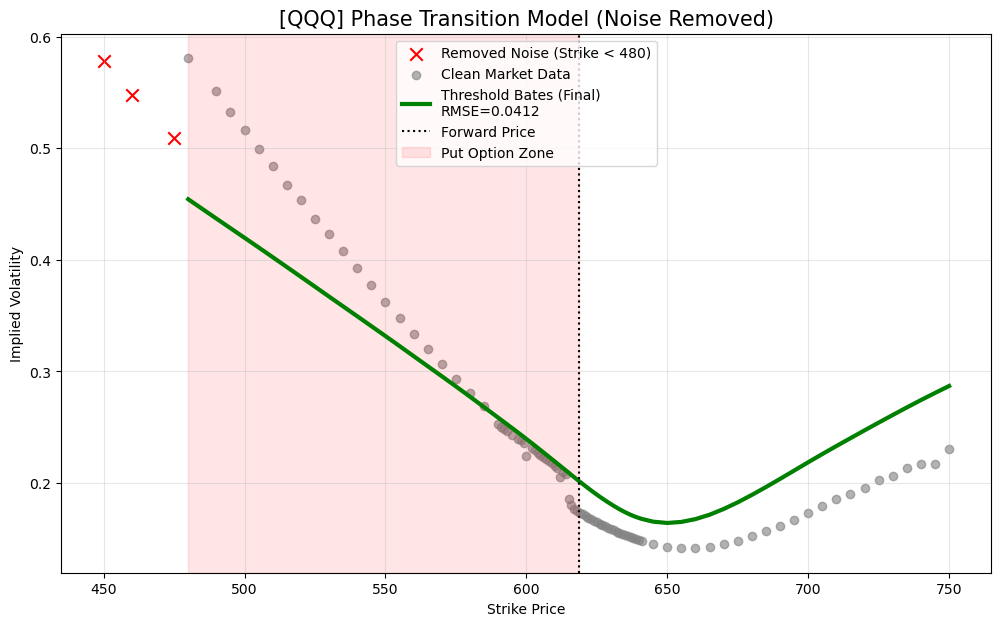


🏆 [Table 1] Final Estimated Parameters (Noise Filtered)
Parameter                 | Value      | Meaning
------------------------------------------------------------
Threshold (K_vol)         | 0.3987     | Critical Volatility Level
Lambda (Normal)           | 0.4411     | Jump Intensity (Normal)
Lambda (Panic)            | 1.7631     | Jump Intensity (Panic)
Risk Multiplier           | 4.00x      | Panic / Normal Ratio
------------------------------------------------------------
Final RMSE: 0.04120


In [11]:
# [Cell 5] 결과 그래프 및 테이블

p = res_final.x
# 그래프는 깨끗한 데이터 범위로 그림
strikes_all = calls_clean['strike'].values 
strikes_gpu_all = torch.tensor(strikes_all, device=device, dtype=torch.float32)

p_dict = {'kappa':p[0], 'theta':p[1], 'xi':p[2], 'rho':p[3], 
          'thresh':p[4], 'lam_low':p[5], 'lam_high':p[6], 'mu':p[7], 'sig':p[8]}

S_sim = simulate_threshold_bates(S0_forward, T_v, 1/252, 30000, p_dict, device=device)
S_sim = S_sim * (S0_forward / S_sim.mean())
payoffs = torch.maximum(S_sim.unsqueeze(1) - strikes_gpu_all.unsqueeze(0), torch.tensor(0.0, device=device))
prices = torch.mean(payoffs, dim=0).cpu().numpy()
model_ivs = implied_vol_cpu(prices, S0_forward, strikes_all, T_v)

# Graph
plt.figure(figsize=(12, 7))

# 1. 제거된 노이즈 (X 표시)
noise_data = calls[calls['strike'] < 480]
plt.scatter(noise_data['strike'], noise_data['impliedVolatility'], 
            c='red', marker='x', s=80, label='Removed Noise (Strike < 480)')

# 2. 사용된 데이터
plt.scatter(calls_clean['strike'], calls_clean['impliedVolatility'], 
            c='gray', alpha=0.6, label='Clean Market Data')

# 3. 모델
plt.plot(strikes_all, model_ivs, 'g-', linewidth=3, label=f'Threshold Bates (Final)\nRMSE={res_final.fun:.4f}')

plt.axvline(S0_forward, color='k', linestyle=':', label='Forward Price')
plt.axvspan(calls_clean['strike'].min(), S0_forward, alpha=0.1, color='red', label='Put Option Zone')

plt.title(f"[{ticker}] Phase Transition Model (Noise Removed)", fontsize=15)
plt.xlabel("Strike Price"); plt.ylabel("Implied Volatility")
plt.legend(loc='upper center'); plt.grid(True, alpha=0.3)
plt.show()

# Table
print("\n" + "="*60)
print("🏆 [Table 1] Final Estimated Parameters (Noise Filtered)")
print("="*60)
print(f"{'Parameter':<25} | {'Value':<10} | {'Meaning'}")
print("-" * 60)
print(f"{'Threshold (K_vol)':<25} | {np.sqrt(p[4]):.4f}     | Critical Volatility Level")
print(f"{'Lambda (Normal)':<25} | {p[5]:.4f}     | Jump Intensity (Normal)")
print(f"{'Lambda (Panic)':<25} | {p[6]:.4f}     | Jump Intensity (Panic)")
print(f"{'Risk Multiplier':<25} | {p[6]/p[5]:.2f}x      | Panic / Normal Ratio")
print("-" * 60)
print(f"Final RMSE: {res_final.fun:.5f}")
print("="*60)


🥊 [Final Solution] OTM 스위칭 적용 + RMSE 계산 보완
🎨 그래프 복구 및 RMSE 계산 중...


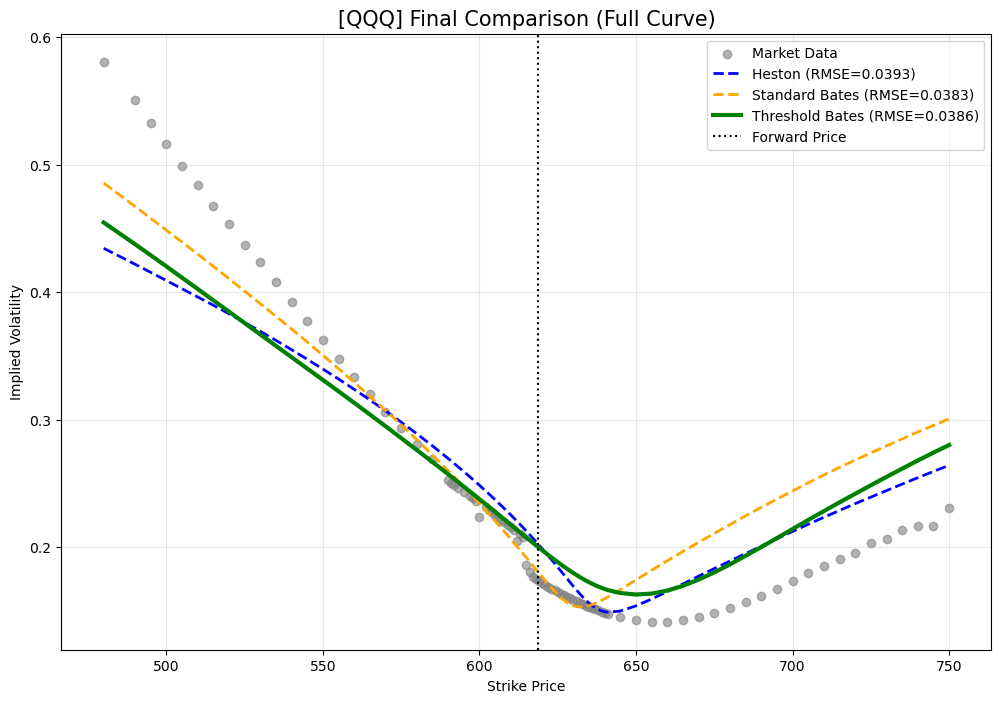


🏆 [Table 2] Fair Comparison Result (Valid RMSE)
Model                     | RMSE       | Valid Points
------------------------------------------------------------
Heston                    | 0.03932     | 92/92
Standard Bates            | 0.03828     | 92/92
Threshold Bates           | 0.03857     | 92/92


In [15]:
# [Cell 6] Final Comparison (RMSE Calculation Fix)

print("\n" + "="*60)
print("🥊 [Final Solution] OTM 스위칭 적용 + RMSE 계산 보완")
print("="*60)

# ... (calculate_iv_robust, get_model_curve 함수는 이전과 동일하므로 생략 가능하나, 안전을 위해 전체 코드 다시 제공) ...

# ---------------------------------------------------------
# 1. Improved IV Calculator (Handle Puts & Calls)
# ---------------------------------------------------------
def calculate_iv_robust(prices, S, K_array, T, option_type='call'):
    ivs = []
    for i, p in enumerate(prices):
        K = K_array[i]
        if option_type == 'call': intrinsic = max(0, S - K)
        else: intrinsic = max(0, K - S)
        
        if p < intrinsic + 1e-6 or p <= 0:
            ivs.append(np.nan); continue
            
        def obj(sigma):
            d1 = (np.log(S/K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
            d2 = d1 - sigma * np.sqrt(T)
            if option_type == 'call': theo = S * norm.cdf(d1) - K * norm.cdf(d2)
            else: theo = K * norm.cdf(-d2) - S * norm.cdf(-d1)
            return theo - p
            
        try: ivs.append(brentq(obj, 1e-4, 5.0, maxiter=100))
        except: ivs.append(np.nan)
    return np.array(ivs)

# ---------------------------------------------------------
# 2. Simulation Wrapper (Auto Put/Call Switching)
# ---------------------------------------------------------
def get_model_curve(params, model_type, strikes, S0, T, num_paths=50000):
    torch.manual_seed(42)
    strikes_gpu = torch.tensor(strikes, device=device, dtype=torch.float32)
    
    if model_type == 'heston':
        p_dict = {'kappa':params[0], 'theta':params[1], 'xi':params[2], 'rho':params[3],
                  'thresh':0, 'lam_low':0, 'lam_high':0, 'mu':0, 'sig':0}
    elif model_type == 'bates':
        p_dict = {'kappa':params[0], 'theta':params[1], 'xi':params[2], 'rho':params[3],
                  'thresh':0, 'lam_low':params[4], 'lam_high':params[4], 'mu':params[5], 'sig':params[6]}
    else: # Ours
        p_dict = {'kappa':params[0], 'theta':params[1], 'xi':params[2], 'rho':params[3],
                  'thresh':params[4], 'lam_low':params[5], 'lam_high':params[6], 'mu':params[7], 'sig':params[8]}

    S_T = simulate_threshold_bates(S0, T, 1/252, num_paths, p_dict, device=device)
    S_T = S_T * (S0 / S_T.mean()) 
    
    final_ivs = []
    for K in strikes:
        if K < S0: # OTM Put
            payoff = torch.maximum(torch.tensor(K, device=device) - S_T, torch.tensor(0.0, device=device))
            price = torch.mean(payoff).item()
            iv = calculate_iv_robust([price], S0, [K], T, option_type='put')[0]
        else: # OTM Call
            payoff = torch.maximum(S_T - torch.tensor(K, device=device), torch.tensor(0.0, device=device))
            price = torch.mean(payoff).item()
            iv = calculate_iv_robust([price], S0, [K], T, option_type='call')[0]
        final_ivs.append(iv)
    return np.array(final_ivs)

# ---------------------------------------------------------
# 3. Visualization & RMSE Calculation
# ---------------------------------------------------------
print("🎨 그래프 복구 및 RMSE 계산 중...")
strikes_all = calls_clean['strike'].values 
market_ivs = calls_clean['impliedVolatility'].values

# (1) Heston
iv_h = get_model_curve(res_h.x, 'heston', strikes_all, S0_forward, T_v)
mask_h = ~np.isnan(iv_h)
rmse_h = np.sqrt(np.mean((iv_h[mask_h] - market_ivs[mask_h])**2)) if np.sum(mask_h) > 0 else np.nan

# (2) Bates
iv_b = get_model_curve(res_b.x, 'bates', strikes_all, S0_forward, T_v)
mask_b = ~np.isnan(iv_b)
rmse_b = np.sqrt(np.mean((iv_b[mask_b] - market_ivs[mask_b])**2)) if np.sum(mask_b) > 0 else np.nan

# (3) Our Model
if 'res_final' in locals():
    iv_ours = get_model_curve(res_final.x, 'ours', strikes_all, S0_forward, T_v)
    mask_ours = ~np.isnan(iv_ours)
    rmse_ours = np.sqrt(np.mean((iv_ours[mask_ours] - market_ivs[mask_ours])**2)) if np.sum(mask_ours) > 0 else np.nan
else:
    iv_ours = np.zeros_like(strikes_all); rmse_ours = 0

# Plotting
plt.figure(figsize=(12, 8))
plt.scatter(calls_clean['strike'], calls_clean['impliedVolatility'], c='gray', alpha=0.6, label='Market Data')
plt.plot(strikes_all, iv_h, 'b--', linewidth=2, label=f'Heston (RMSE={rmse_h:.4f})')
plt.plot(strikes_all, iv_b, 'orange', linestyle='--', linewidth=2, label=f'Standard Bates (RMSE={rmse_b:.4f})')
plt.plot(strikes_all, iv_ours, 'g-', linewidth=3, label=f'Threshold Bates (RMSE={rmse_ours:.4f})')

plt.axvline(S0_forward, color='k', linestyle=':', label='Forward Price')
plt.title(f"[{ticker}] Final Comparison (Full Curve)", fontsize=15)
plt.xlabel("Strike Price"); plt.ylabel("Implied Volatility")
plt.legend(loc='best'); plt.grid(True, alpha=0.3)
plt.show()

print("\n" + "="*60)
print("🏆 [Table 2] Fair Comparison Result (Valid RMSE)")
print("="*60)
print(f"{'Model':<25} | {'RMSE':<10} | {'Valid Points'}")
print("-" * 60)
print(f"{'Heston':<25} | {rmse_h:.5f}     | {np.sum(mask_h)}/{len(market_ivs)}")
print(f"{'Standard Bates':<25} | {rmse_b:.5f}     | {np.sum(mask_b)}/{len(market_ivs)}")
print(f"{'Threshold Bates':<25} | {rmse_ours:.5f}     | {np.sum(mask_ours)}/{len(market_ivs)}")
print("="*60)